# Supervised Learning - Class 7

## From Decision Trees to Random Forests

### Agenda
1. Introduction to Decision Trees
2. Example of diabetes prediction with Decision Trees
    - Gini impurity
    - Depth, leaves, overfitting
3. Random Forests

## 0. Import packages

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score,  roc_curve, auc, make_scorer

np.random.seed(0)

## 1. Introduction to Decision Trees: a simple example

Generating synthetic data for illustration

In [2]:
# Generate integer synthetic data
SBP = np.random.randint(80, 160, 100)  # Systolic Blood Pressure in mmHg
TCL = np.random.randint(100, 300, 100)  # Total Cholesterol Level in mg/dL

# Combine the features into a single array
X = np.column_stack((SBP, TCL))

# Generate binary labels based on a threshold condition
y = (SBP + TCL > 300).astype(int)

Plotting the data points pairs (Systolic Blood Pressure --- Total Cholesterol Level)

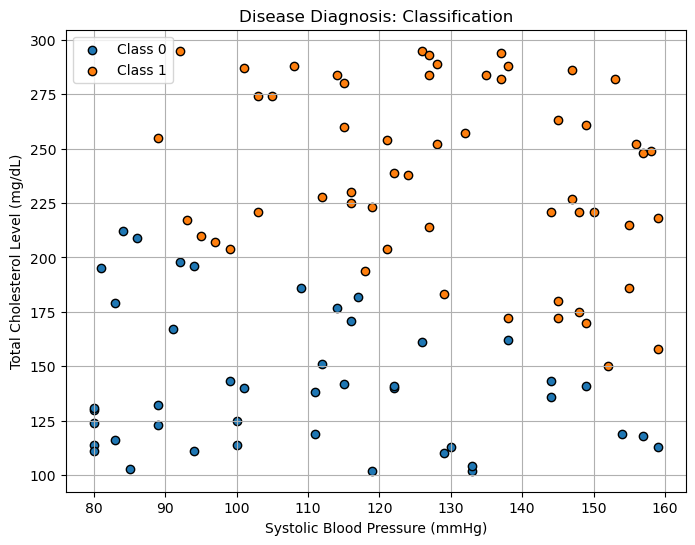

In [3]:
# Plot the synthetic data points
plt.figure(figsize=(8, 6))
for label in np.unique(y):
    plt.scatter(X[y == label][:, 0], X[y == label][:, 1], label=f'Class {label}', edgecolor='k')

plt.title('Disease Diagnosis: Classification')
plt.xlabel('Systolic Blood Pressure (mmHg)')
plt.ylabel('Total Cholesterol Level (mg/dL)')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
# Train a decision tree classifier
dt_classifier = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_classifier.fit(X, y)

DecisionTreeClassifier(max_depth=3, random_state=42)

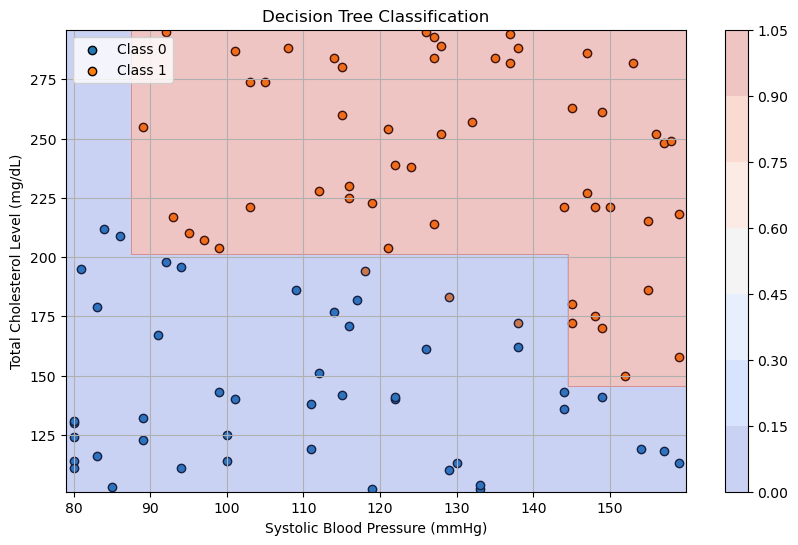

In [5]:
# Plotting the data points
plt.figure(figsize=(10, 6))
for label in np.unique(y):
    plt.scatter(X[y == label][:, 0], X[y == label][:, 1], label=f'Class {label}', edgecolor='k')

# Decision boundary
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
Z = dt_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.colorbar()

plt.title('Decision Tree Classification')
plt.xlabel('Systolic Blood Pressure (mmHg)')
plt.ylabel('Total Cholesterol Level (mg/dL)')
plt.legend()
plt.grid(True)
plt.show()

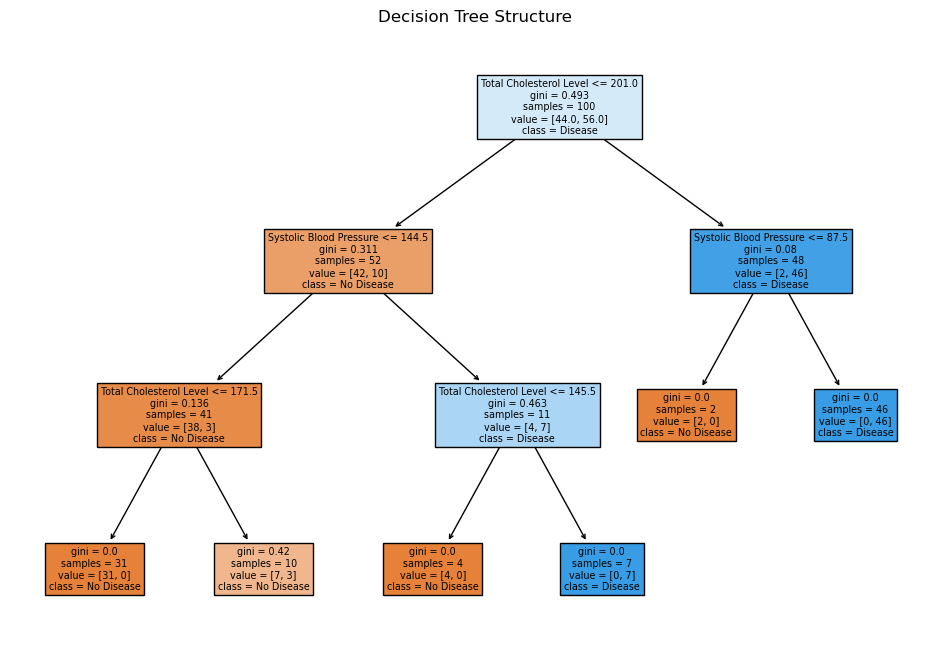

In [6]:
# Visualizing the decision tree
plt.figure(figsize=(12, 8))
plot_tree(dt_classifier, feature_names=['Systolic Blood Pressure', 'Total Cholesterol Level'], class_names=['No Disease', 'Disease'], filled=True)
plt.title('Decision Tree Structure')
plt.show()

## 2. Decision Trees

Decision trees are a type of supervised learning algorithm used for both classification and regression tasks. 

They work by splitting the data into subsets based on the value of input features, creating a tree-like model of decisions. 

Each internal node of the tree represents a feature, each branch represents a decision rule, and each leaf node represents an outcome (class label or regression value).

### Attributes of Decision Trees

1. **Root Node**: The topmost node in a decision tree. It represents the entire dataset and is split into two or more homogeneous sets.
2. **Decision Nodes**: Nodes that represent a decision to be made on a specific attribute, leading to further branching.
3. **Leaf Nodes**: Terminal nodes that provide the final classification or prediction.
4. **Branches**: Edges connecting the nodes, representing the outcome of a decision at each node.

### Splitting Criteria

The process of splitting the nodes involves selecting the best attribute that partitions the data into the most homogeneous subsets. The criteria for selecting the best split include:

- **Gini Impurity**: Measures the likelihood of an incorrect classification of a randomly chosen element if it were randomly labeled according to the distribution of labels in the subset.
  
The Gini impurity is calculated as:

$$\text{Gini} = 1 - \sum_{i=1}^{n} (p_i)^2$$

where $p_i$ is the probability of an element being classified into a particular class. 

A Gini impurity of 0 indicates perfect classification, while a value close to 0.5 indicates a random distribution of elements among classes.

- **Information Gain**: Measures the reduction in entropy (uncertainty) before and after a split.
- **Chi-Square**: Statistical significance test for independence between feature and class.

### Gini Impurity Example

Consider a node containing a mix of elements from two classes, $A$ and $B$. If 70% of elements are from class $A$ and 30% from class $B$, the Gini impurity is:

$$\text{Gini} = 1 - (0.7^2 + 0.3^2) = 1 - (0.49 + 0.09) = 1 - 0.58 = 0.42$$

A split that results in purer child nodes (nodes with elements mostly from one class) is preferred, as it reduces the Gini impurity.


### **Decision trees in practice...**

![](https://miro.medium.com/v2/resize:fit:1394/1*6-ctYxKmTS8v0RzwLILfXA.png)

### Use-case with the PIMA diabetes classification

#### Load the data

In [7]:
data = pd.read_csv('https://raw.githubusercontent.com/Hospital-Da-Luz-Learning-Health/MLCatolica24/main/Aula%207%20-%20Supervised%20Learning%20III/data/diabetes.csv')

In [8]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [9]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


#### EDA

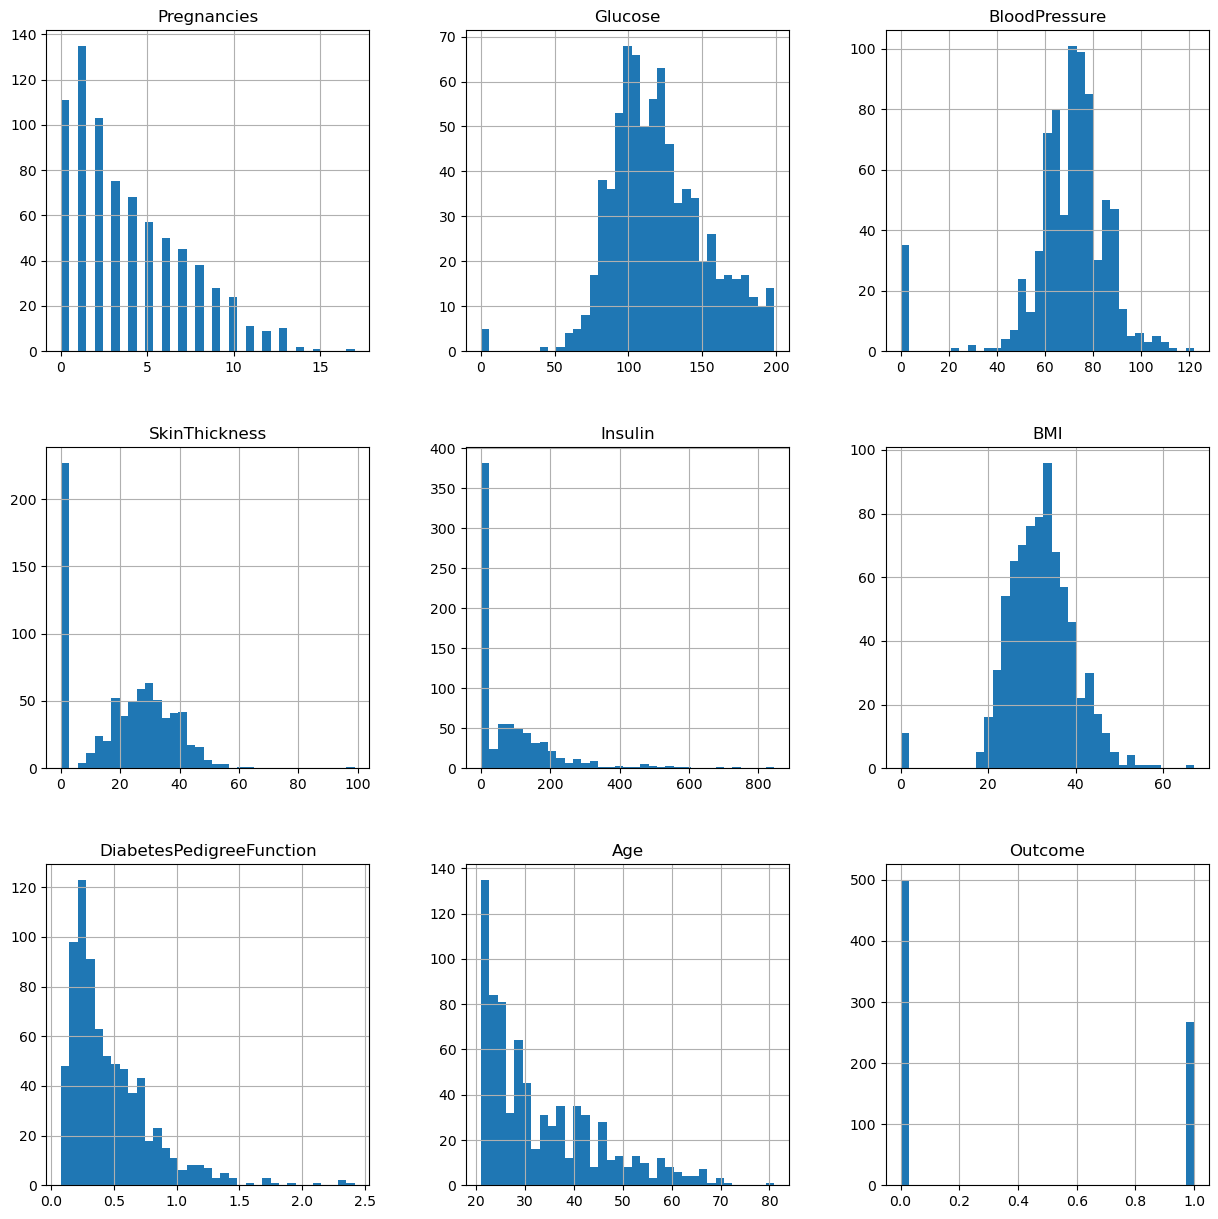

In [10]:
hists = data.hist(bins=35, figsize=(15,15))
plt.show()

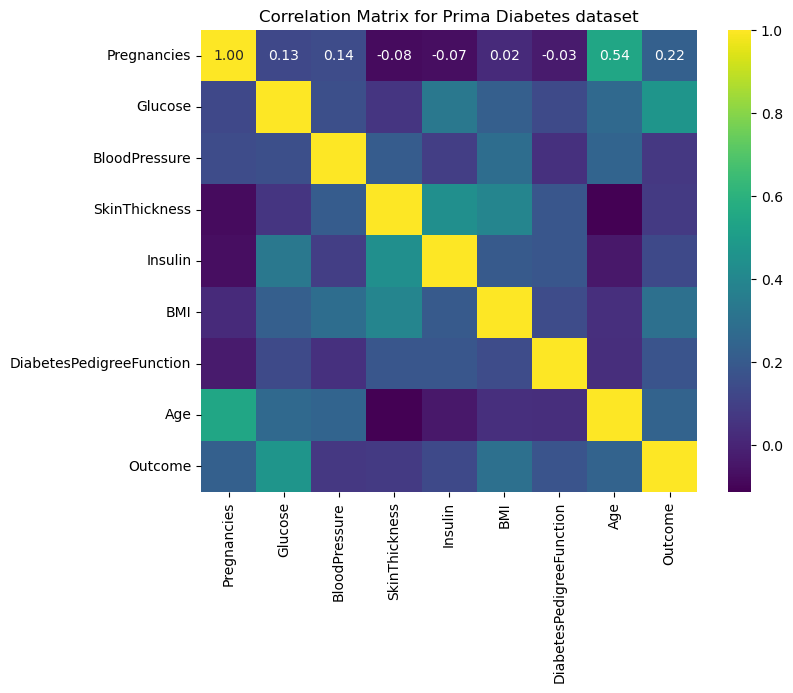

In [11]:
# Calculate the correlation matrix
correlation_matrix = data.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap= 'viridis',fmt='.2f')
plt.title('Correlation Matrix for Prima Diabetes dataset')
plt.show()

#### Data Selection

In [12]:
X = data.drop('Outcome', axis=1)  # Independent variables
y = data['Outcome']  # Dependent variable (target)

In [13]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [14]:
y.head()

0    1
1    0
2    1
3    0
4    1
Name: Outcome, dtype: int64

#### Train/Test Split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [16]:
# Checking the shapes to get an understanding of the problem
print( X_train.shape, X_test.shape )
print( y_train.shape, y_test.shape )

(614, 8) (154, 8)
(614,) (154,)


#### Standardization

**Decision Trees and Feature Scale:**
- Decision trees make splits based on thresholds on individual features, and these splits are not affected by the scale of the features. 
- Therefore, features with different scales will not affect the performance of the tree.

#### Train the model

In [17]:
dtree=DecisionTreeClassifier()
dtree.fit(X_train,y_train)

DecisionTreeClassifier()

let's just check the predictions in the train dataset...

In [18]:
y_pred_train = dtree.predict(X_train)
accuracy = accuracy_score(y_train, y_pred_train)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 1.00


#### Predict and evaluate the model performance

In [19]:
y_predict = dtree.predict(X_test)

In [20]:
accuracy = accuracy_score(y_test, y_predict)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.77


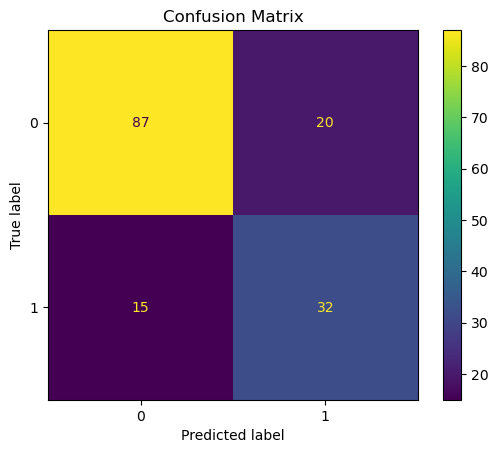

In [21]:
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=dt_classifier.classes_)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

How does the tree looks like?

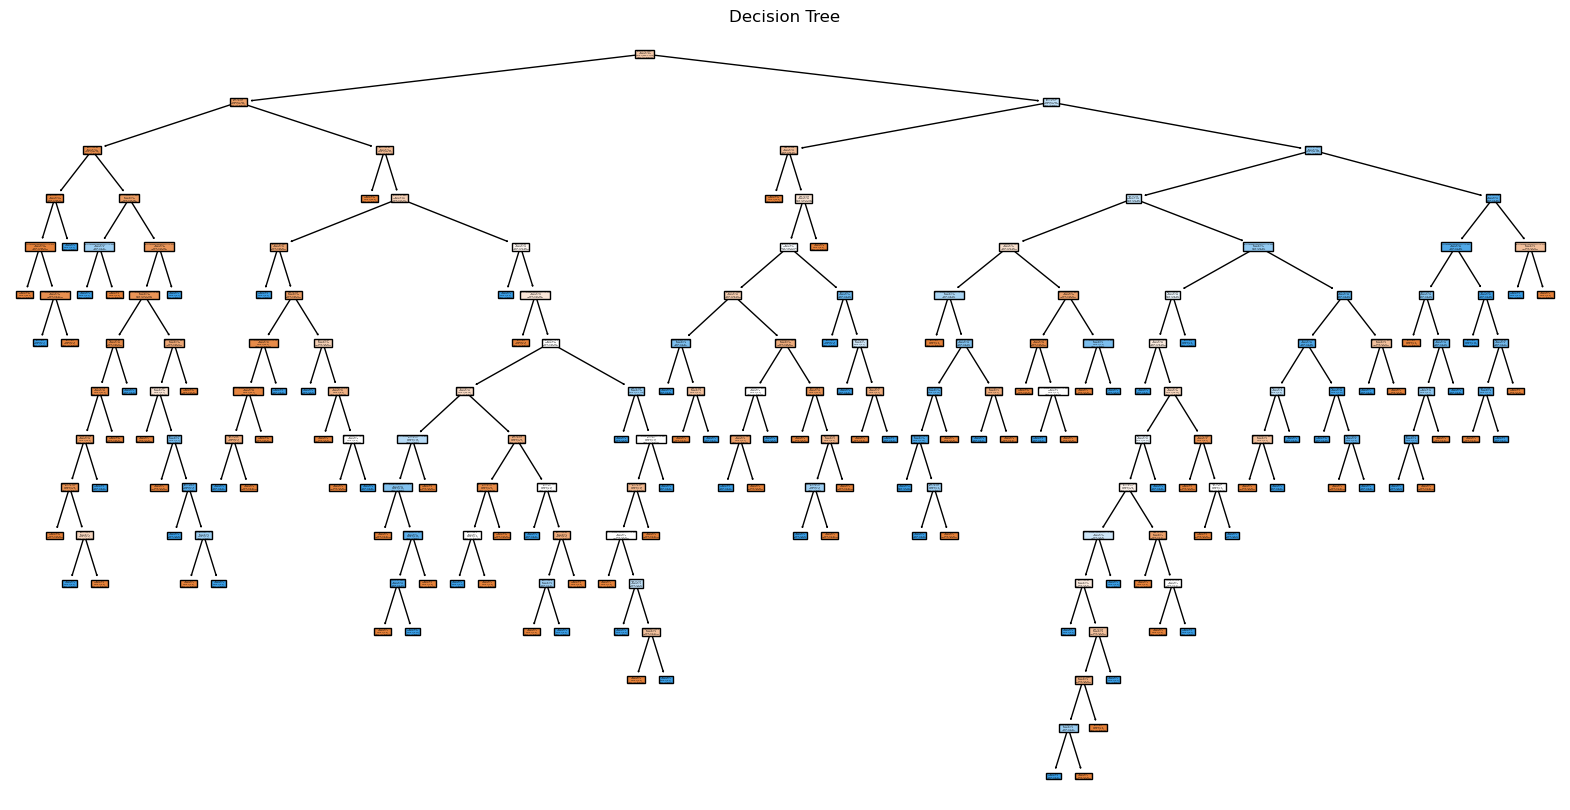

In [22]:
# Visualize the Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(dtree, feature_names=X.columns, class_names=['No Diabetes', 'Diabetes'], filled=True)
plt.title('Decision Tree')
plt.show()

**The model is overfitting the data!!**

#### Train a new decision tree to avoid overfitting the dataset --> limiting the depthn of the tree

In [23]:
# Train the Pruned Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(
    random_state=42,
    max_depth=3
)
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [24]:
y_pred_train = dt_classifier.predict(X_train)
accuracy = accuracy_score(y_train, y_pred_train)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.76


In [25]:
y_pred = dt_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.76


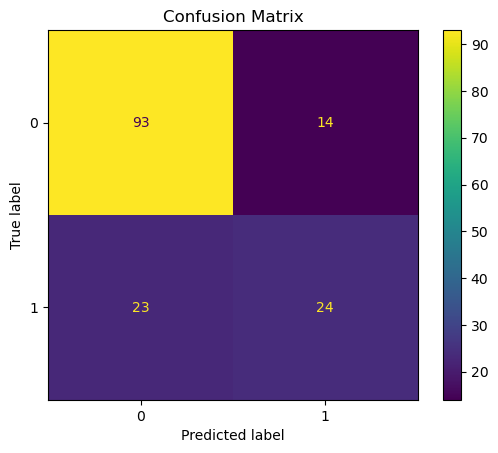

In [26]:
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=dt_classifier.classes_)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

The acurracy for the train dataset is smaller, but the model is already better in generalize for new datapoints it has not seen.

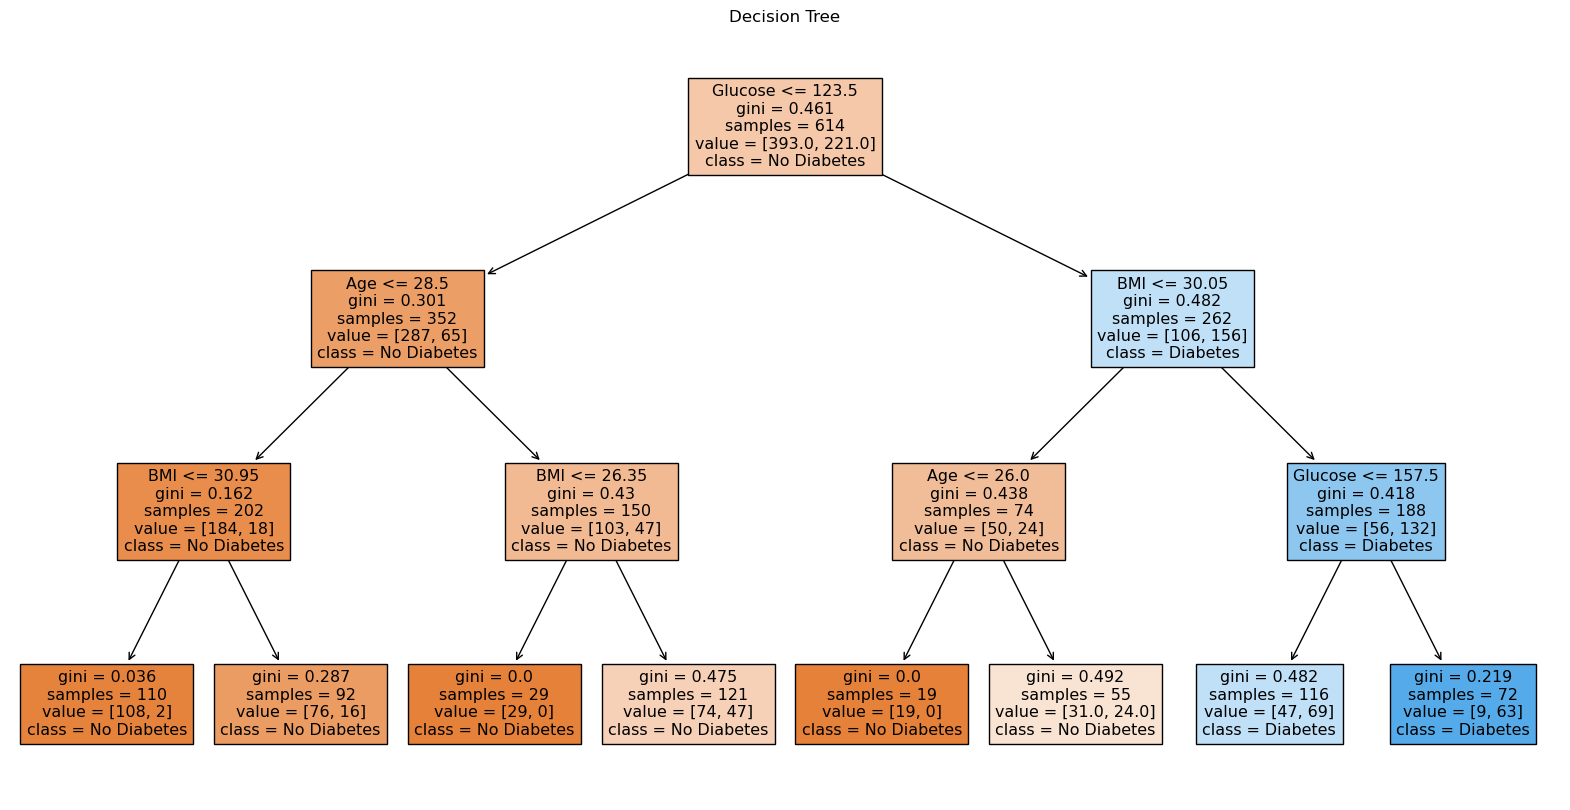

In [27]:
# Visualize the Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(dt_classifier, feature_names=X.columns, class_names=['No Diabetes', 'Diabetes'], filled=True)
plt.title('Decision Tree')
plt.show()

#### Check the parameter impact

In [28]:
# Function to plot the impact of a parameter on train and test accuracy
def plot_parameter_impact(parameter_name, parameter_values, **kwargs):
    train_accuracies = []
    test_accuracies = []

    for value in parameter_values:
        model = DecisionTreeClassifier(**{parameter_name: value}, **kwargs)
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        train_accuracies.append(accuracy_score(y_train, y_train_pred))
        test_accuracies.append(accuracy_score(y_test, y_test_pred))
    
    plt.figure(figsize=(8, 4))
    plt.plot(parameter_values, train_accuracies, label='Train Accuracy')
    plt.plot(parameter_values, test_accuracies, label='Test Accuracy')
    plt.xlabel(parameter_name)
    plt.ylabel('Accuracy')
    plt.title(f'Impact of {parameter_name} on Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

**Increasing the depth of the tree (max_depth):**

- This parameter specifies the maximum depth of the tree. The depth of the tree is the length of the longest path from the root node to a leaf node.

Effect: Limiting the depth of the tree helps in controlling its complexity. A tree that is too deep will have many nodes and will likely overfit the training data. By setting a maximum depth, you prevent the tree from growing too complex, which can help improve generalization to unseen data

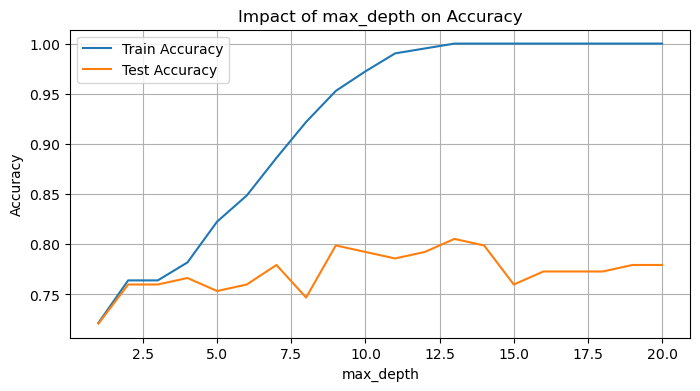

In [29]:
max_depth_values = range(1, 21)
plot_parameter_impact('max_depth', max_depth_values)

**Decreasing the number of samples required to split an internal node (min_samples_split):**

Effect: If a node has fewer than min_samples_split samples, it will not be split and will become a leaf node. Increasing this value helps in creating nodes that have a sufficient number of samples, which can help reduce overfitting. It ensures that splits are not made too early on nodes with very few samples, which might be noise in the data.

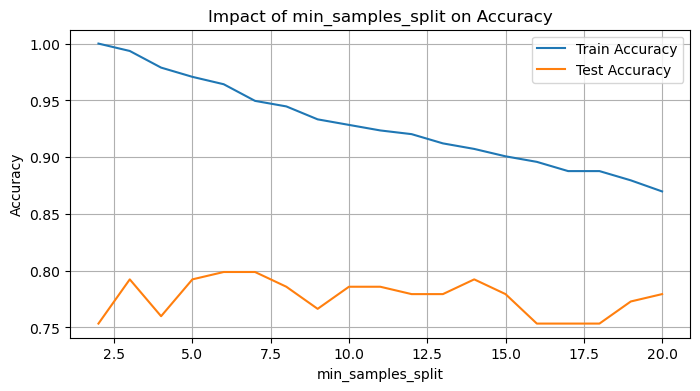

In [30]:
min_samples_split_values = range(2, 21)
plot_parameter_impact('min_samples_split', min_samples_split_values)

**Decreasing the number of samples that a leaf node must have (min_samples_leaf):**

Effect: If a split results in any leaf node having fewer than min_samples_leaf samples, the split will not be made. This parameter helps in smoothing the model by ensuring that leaf nodes have enough samples. It avoids the creation of nodes that represent very small subsets of data, which might be overly specific and could lead to overfitting.

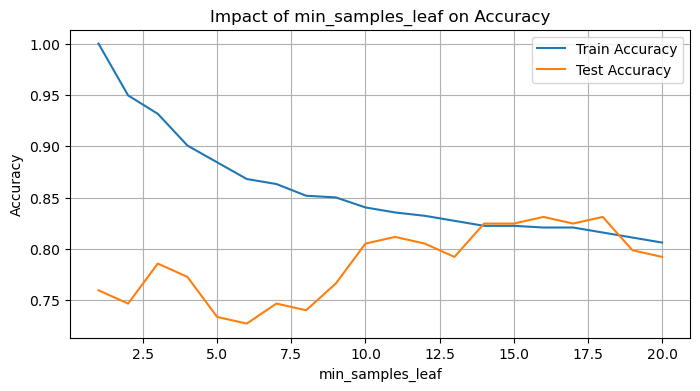

In [31]:
min_samples_leaf_values = range(1, 21)
plot_parameter_impact('min_samples_leaf', min_samples_leaf_values)

Many other attributes that can be change to avoid overfitting:
- **max_features:** The number of features to consider when looking for the best split.
- **max_leaf_nodes:** The maximum number of leaf nodes in the tree.
- **min_weight_fraction_leaf:** The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node.
- **ccp_alpha:** The complexity parameter used for Minimal Cost-Complexity Pruning. The larger the value, the more the pruning.

#### Train a new model with some parameters that can obtain a better accuracy witouth overfitting the data

In [32]:
# Define Decision Tree Parameters
max_depth = 5
min_samples_split = 10
min_samples_leaf = 10
max_leaf_nodes = 15

# Create and fit the Decision Tree model with specified parameters
DT_model = DecisionTreeClassifier(max_depth=max_depth,
                               min_samples_split=min_samples_split,
                               min_samples_leaf=min_samples_leaf,
                               max_leaf_nodes=max_leaf_nodes)

DT_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=15, min_samples_leaf=10,
                       min_samples_split=10)

In [33]:
y_pred_train = DT_model.predict(X_train)
accuracy = accuracy_score(y_train, y_pred_train)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.81


In [34]:
y_pred = DT_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.80


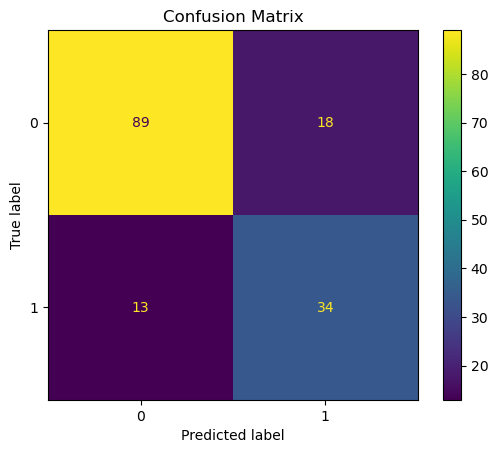

In [35]:
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=dt_classifier.classes_)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

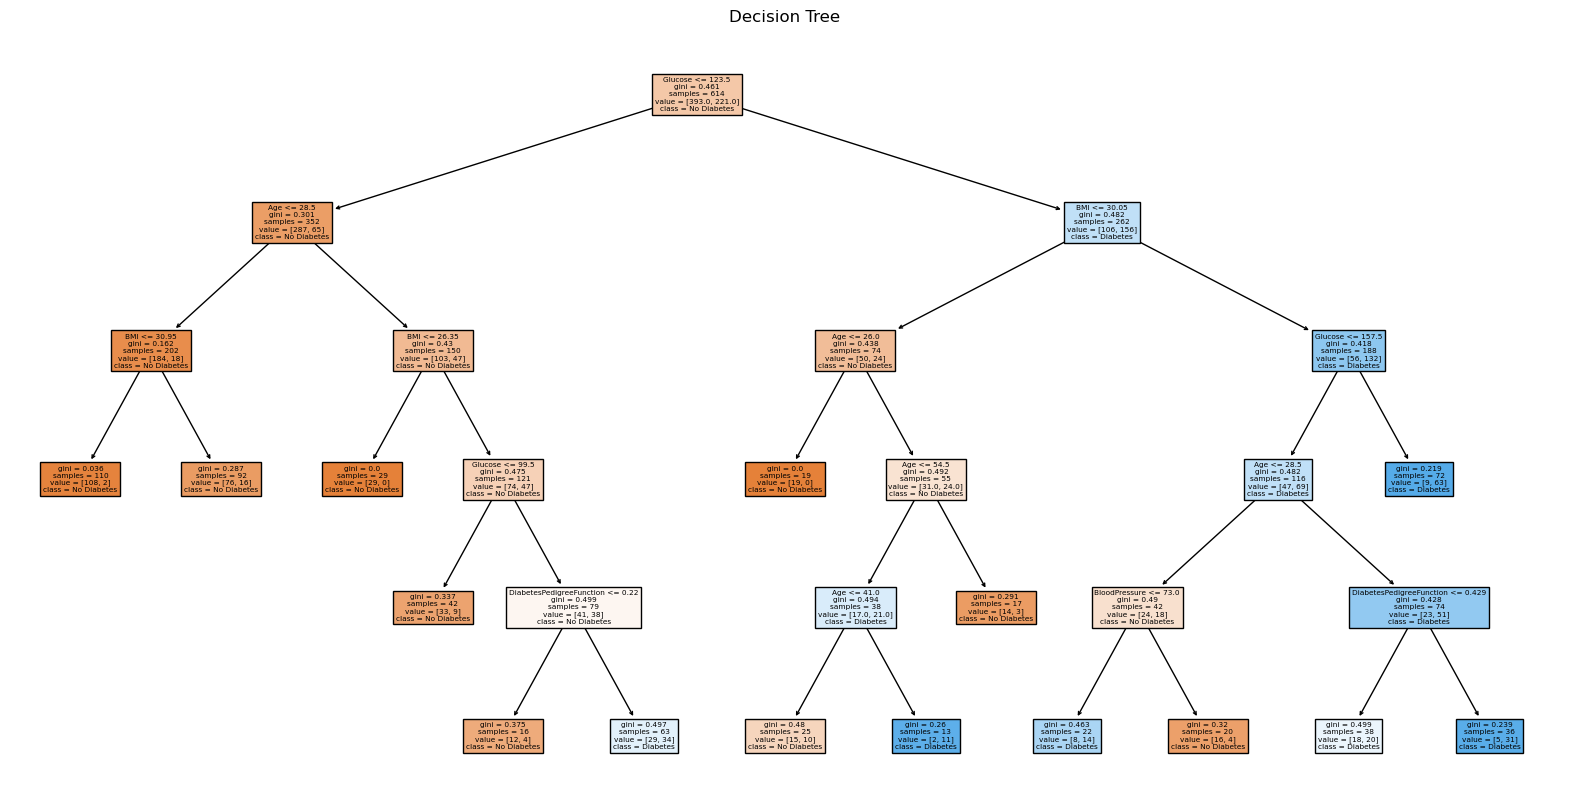

In [36]:
# Visualize the Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(DT_model, feature_names=X.columns, class_names=['No Diabetes', 'Diabetes'], filled=True)
plt.title('Decision Tree')
plt.show()

#### The dataset is also influencing the tree structure

In [37]:
# Split the dataset into two halves
X_half1, X_half2, y_half1, y_half2 = train_test_split(X, y, test_size=0.5, random_state=42)

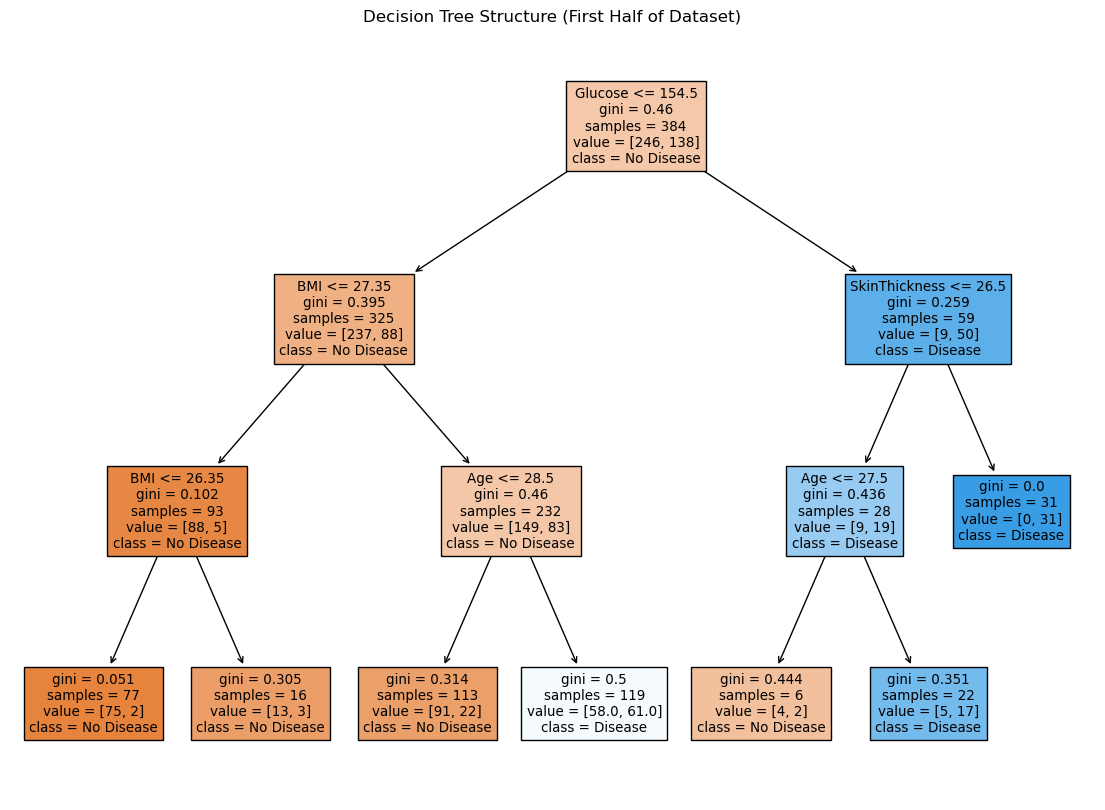

In [38]:
# Train decision tree on the first half
dt_classifier1 = DecisionTreeClassifier(max_depth=3, min_samples_split=10, min_samples_leaf=5)
dt_classifier1.fit(X_half1, y_half1)

# Visualize the first decision tree
plt.figure(figsize=(14, 10))
plot_tree(dt_classifier1, feature_names=X.columns, class_names=['No Disease', 'Disease'], filled=True)
plt.title('Decision Tree Structure (First Half of Dataset)')
plt.show()

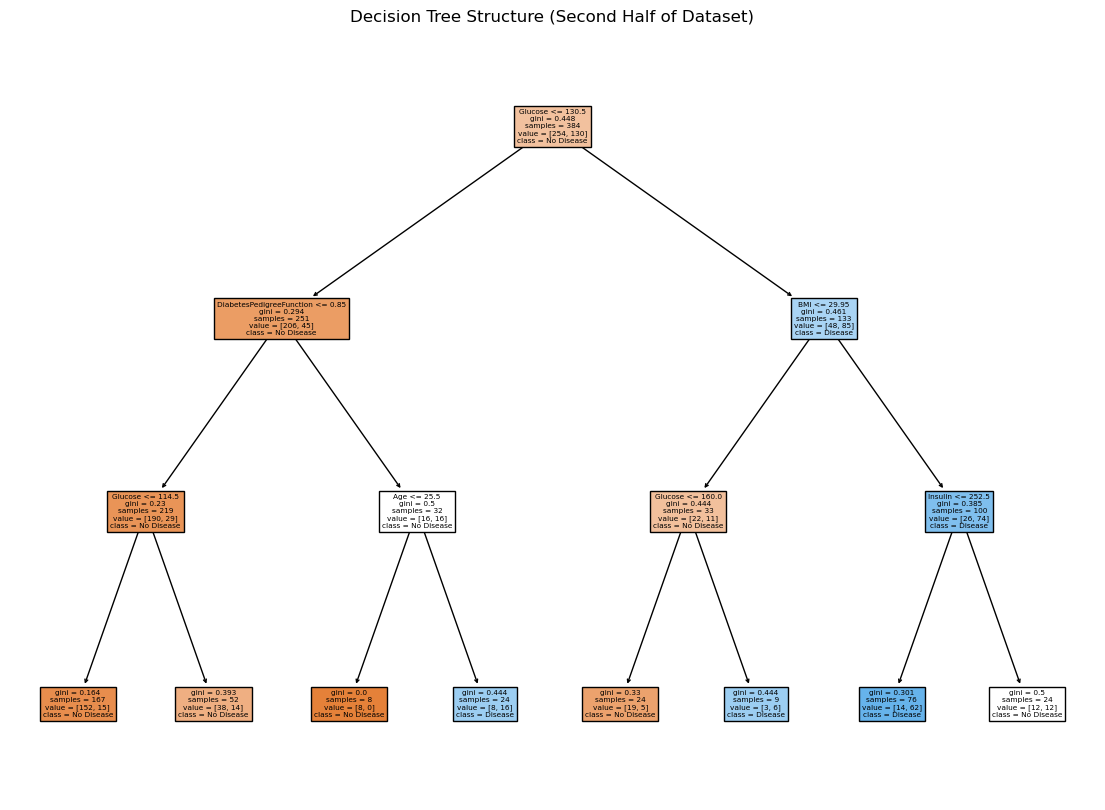

In [39]:
# Train decision tree on the second half
dt_classifier2 = DecisionTreeClassifier(max_depth=3, min_samples_split=10, min_samples_leaf=5)
dt_classifier2.fit(X_half2, y_half2)

# Visualize the second decision tree
plt.figure(figsize=(14, 10))
plot_tree(dt_classifier2, feature_names=X.columns, class_names=['No Disease', 'Disease'], filled=True)
plt.title('Decision Tree Structure (Second Half of Dataset)')
plt.show()

#### Feature Importante

In [40]:
# Retrieve feature importances
feature_importances = DT_model.feature_importances_

In [41]:
# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

In [42]:
# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

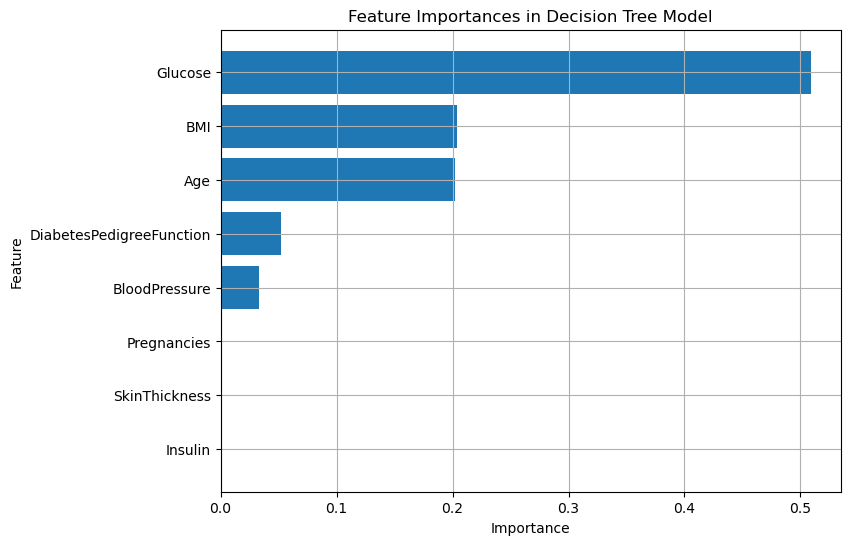

In [43]:
# Plot feature importances
plt.figure(figsize=(8, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in Decision Tree Model')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.grid(True)
plt.show()

### 3. Random Forests

![](https://cnvrg.io/wp-content/uploads/2021/02/Random-Forest-Algorithm-1024x576.jpg)

Random Forests address some of the limitations of individual decision trees, such as overfitting and high variance. 

By averaging multiple decision trees, Random Forests can achieve a more robust and accurate model. Here are some key advantages:

1. **Improved Accuracy:** By combining the predictions of multiple trees, Random Forests can achieve higher accuracy compared to a single decision tree.
2. **Reduced Overfitting:** Averaging multiple trees helps in reducing overfitting, making the model more generalizable to new data.
3. **Robustness:** Random Forests are less sensitive to the noise in the data and provide better performance even when there are missing values.

#### How Random Forests Work:

1.  **Bootstrap Sampling:** Random Forests use bootstrap sampling to generate multiple datasets from the original data. This involves randomly sampling the data with replacement, allowing for some data points to be repeated while others are left out.

2.    **Random Feature Selection:** When constructing each tree, a random subset of features is selected to determine the best split at each node. This randomness helps in creating diverse trees.

3.  **Tree Construction:** Each tree is built using the bootstrapped sample and the randomly selected features. The trees are grown to their maximum depth without pruning.

4.  **Aggregation:** For classification, the final prediction is made by majority voting across all the trees. For regression, the average prediction of all the trees is used.

In [44]:
# Train the Random Forest model
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_split=10, min_samples_leaf=5, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=10,
                       random_state=42)

In [45]:
# Make predictions on the train set
y_predicted_train = rf_classifier.predict(X_train)

accuracy = accuracy_score(y_train, y_predicted_train)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.82


In [46]:
# Make predictions on the test set
y_predicted = rf_classifier.predict(X_test)

In [47]:
accuracy = accuracy_score(y_test, y_predicted)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.82


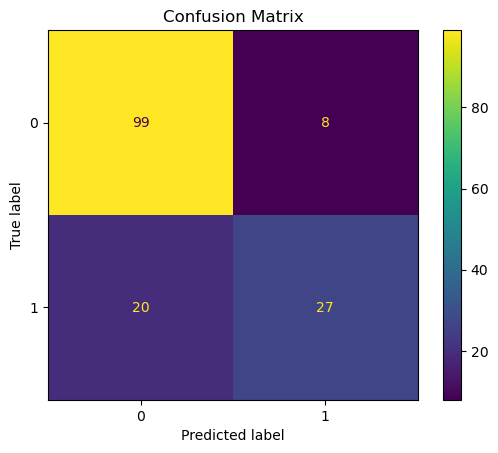

In [48]:
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=dt_classifier.classes_)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

Visualize one of the trees

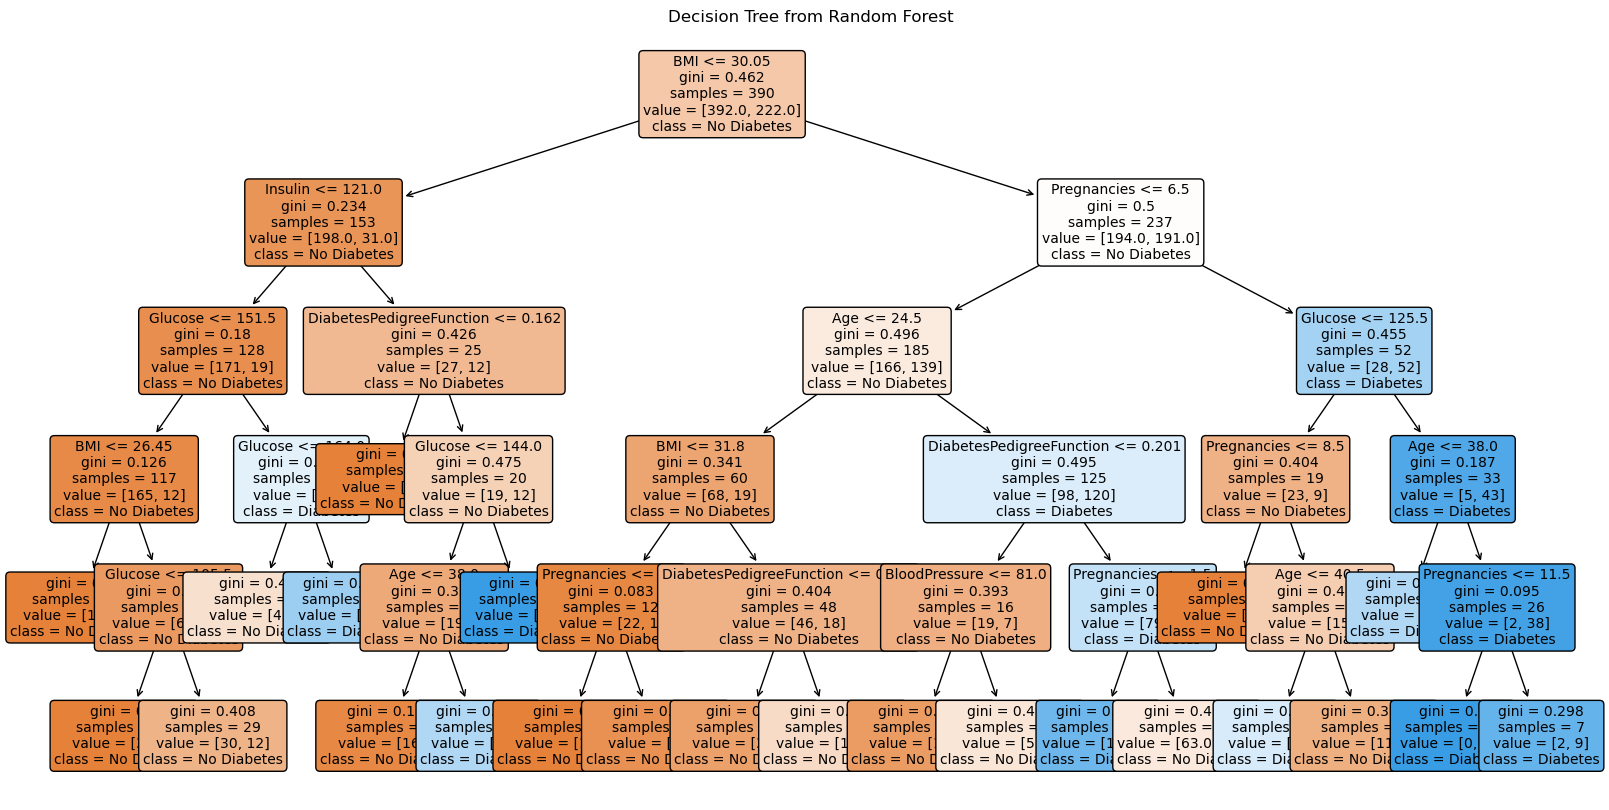

In [54]:
# Select one tree from the forest
one_tree = rf_classifier.estimators_[0]

# Visualize the selected tree
plt.figure(figsize=(20, 10))
plot_tree(one_tree, feature_names=X.columns, class_names=['No Diabetes', 'Diabetes'], filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree from Random Forest')
plt.show()

Feature Importance

In [49]:
# Calculate feature importance
feature_importances = rf_classifier.feature_importances_

In [51]:
# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

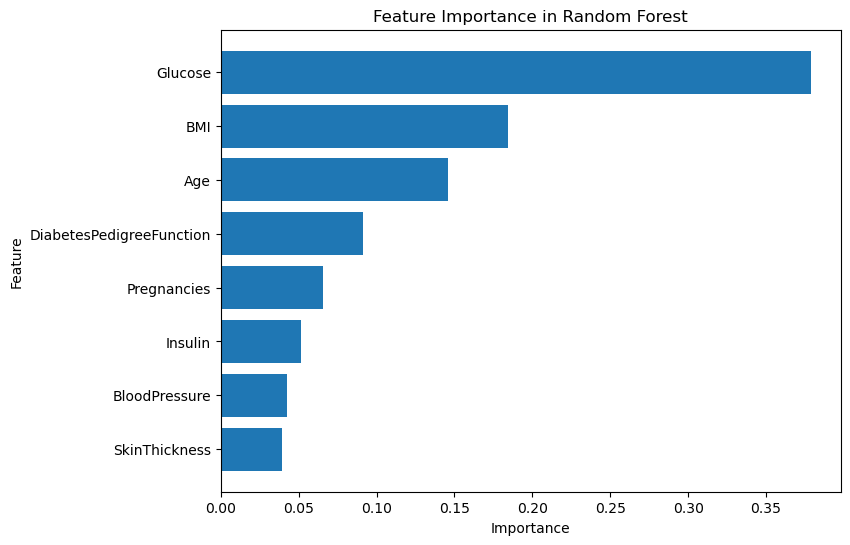

In [53]:
# Plot feature importance
plt.figure(figsize=(8, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest')
plt.gca().invert_yaxis()
plt.show()